# Week 6 Assignment - Link Analysis

The dataset was downloaded from the Stanford Biomedical Network Dataset Collection and represents a Disease-gene association network where nodes are represented by genes and diseases and edges represent the associations between them. The aim of this notebook is to analyze the chosen dataset using the NetworkX package and to find interesting relationships between genes and diseases or between diseases and diseases.

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set
import collections


from networkx.algorithms import bipartite
from networkx import NetworkXError
import networkx.algorithms.community as nxcom
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms import community
import community as community_louvain

In [5]:
# read dataset from disk
df = pd.read_csv('DG-AssocMiner_miner-disease-gene.tsv', sep='\t')

## 1. EDA

In [6]:
df.head()

,# Disease ID,Disease Name,Gene ID
0,C0036095,Salivary Gland Neoplasms,1462
1,C0036095,Salivary Gland Neoplasms,1612
2,C0036095,Salivary Gland Neoplasms,182
3,C0036095,Salivary Gland Neoplasms,2011
4,C0036095,Salivary Gland Neoplasms,2019


In [7]:
df.dtypes

# Disease ID    object
Disease Name    object
Gene ID          int64
dtype: object

In [8]:
df.info

<bound method DataFrame.info of       # Disease ID                    Disease Name  Gene ID
0         C0036095        Salivary Gland Neoplasms     1462
1         C0036095        Salivary Gland Neoplasms     1612
2         C0036095        Salivary Gland Neoplasms      182
3         C0036095        Salivary Gland Neoplasms     2011
4         C0036095        Salivary Gland Neoplasms     2019
5         C0036095        Salivary Gland Neoplasms     2175
6         C0036095        Salivary Gland Neoplasms     2195
7         C0036095        Salivary Gland Neoplasms    23209
8         C0036095        Salivary Gland Neoplasms    23543
9         C0036095        Salivary Gland Neoplasms    23619
10        C0036095        Salivary Gland Neoplasms   259266
11        C0036095        Salivary Gland Neoplasms     2620
12        C0036095        Salivary Gland Neoplasms     2621
13        C0036095        Salivary Gland Neoplasms    27344
14        C0036095        Salivary Gland Neoplasms     2982
15      

In [9]:
df.isnull().sum()

# Disease ID    0
Disease Name    0
Gene ID         0
dtype: int64

In [10]:
df['Disease Name'].value_counts()

Prostatic Neoplasms                                    485
IGA Glomerulonephritis                                 450
Mammary Neoplasms                                      433
Obesity                                                298
Peripheral Neuropathy                                  293
Stomach Neoplasms                                      284
Schizophrenia                                          280
Autistic Disorder                                      254
Colorectal Neoplasms                                   232
Liver carcinoma                                        222
Rheumatoid Arthritis                                   219
melanoma                                               204
Hypertensive disease                                   195
Lung Neoplasms                                         178
Neoplasm Metastasis                                    174
Diabetes Mellitus, Non-Insulin-Dependent               173
Myocardial Ischemia                                    1

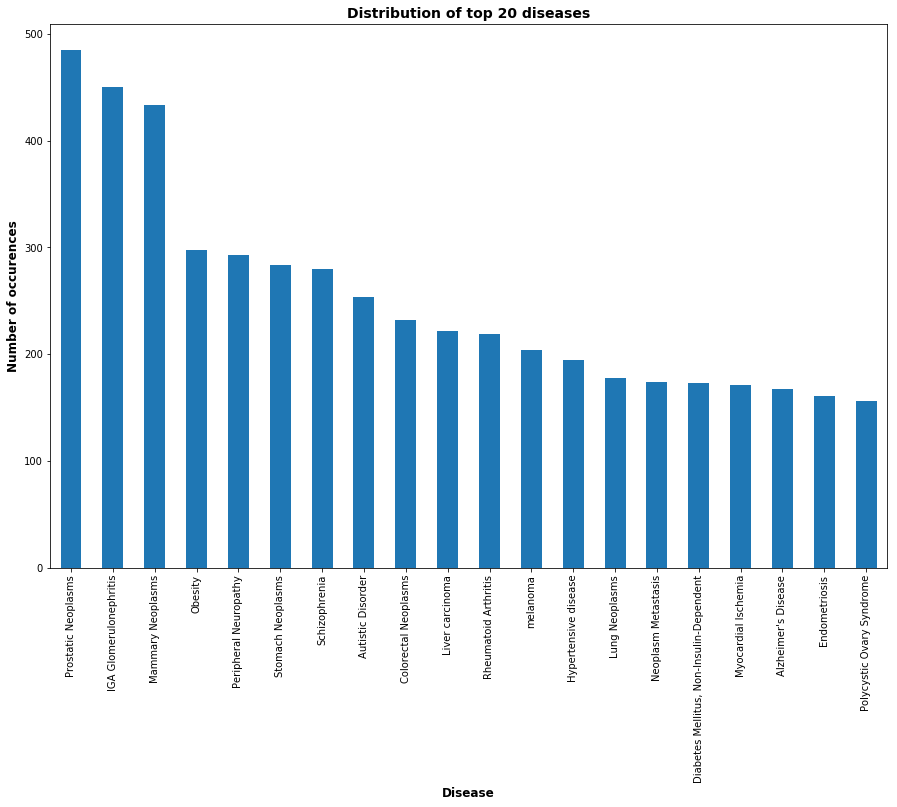

In [11]:
# visualize distribution of disease name
fig = plt.figure(figsize=(15, 10))
df['Disease Name'].value_counts()[0:20].plot(kind='bar')
plt.xticks()
plt.ylabel('Number of occurences', fontsize=12, fontweight='bold')
plt.xlabel('Disease', fontsize=12, fontweight='bold', horizontalalignment='center')
plt.title('Distribution of top 20 diseases', fontsize=14, fontweight='bold')

# export graphic for report
plt.savefig("distribution_diseases.png", bbox_inches = 'tight')

In [12]:
# check for unique ID identifiers
print(f"The total ids are {df['# Disease ID'].count()}, from those the unique ids are {df['# Disease ID'].value_counts().shape[0]} ")

The total ids are 21357, from those the unique ids are 519 


In [13]:
df2 = df['Disease Name'].value_counts() <= 10
df2.tail(50)

Alopecia Areata                                        False
Osteogenesis imperfecta type III (disorder)            False
Neuralgia                                              False
Precursor B-Cell Lymphoblastic Leukemia-Lymphoma       False
Craniosynostosis                                       False
Pathological accumulation of air in tissues            False
Spina Bifida                                           False
Copper-Overload Cirrhosis                              False
Peroxisome biogenesis disorders                        False
Williams Syndrome                                       True
Diarrhea                                                True
Jeune thoracic dystrophy                                True
Cerebral Infarction                                     True
Nephritis, Interstitial                                 True
Tonic-Clonic Epilepsy                                   True
Adenomatous Polyposis Coli                              True
Tachycardia, Ventricular

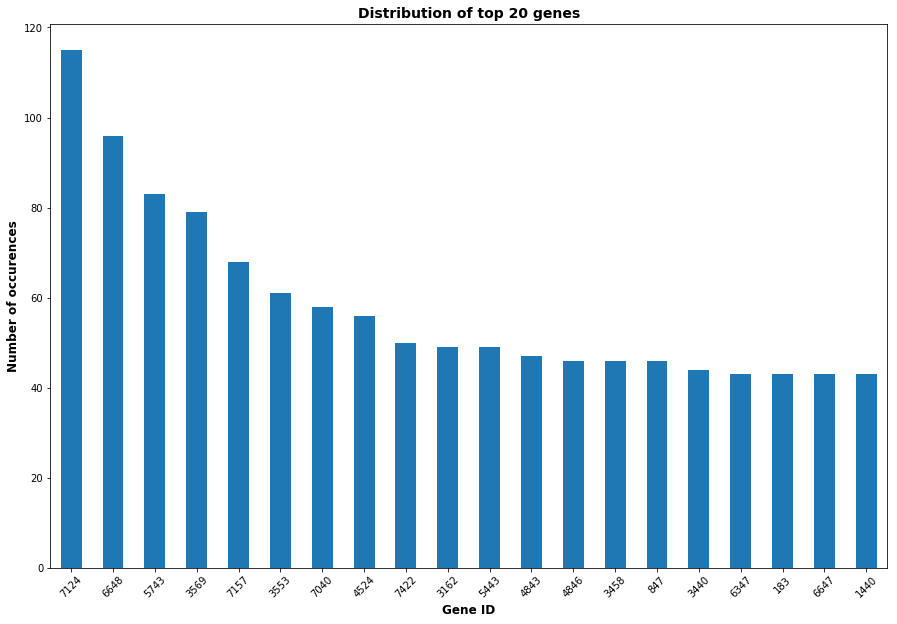

In [14]:
# visualize distribution of genes
fig = plt.figure(figsize=(15, 10))
df['Gene ID'].value_counts()[0:20].plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Number of occurences', fontsize=12, fontweight='bold')
plt.xlabel('Gene ID', fontsize=12, fontweight='bold', horizontalalignment='center')
plt.title('Distribution of top 20 genes', fontsize=14, fontweight='bold')

# export graphic for report
plt.savefig("distribution_genes.png", bbox_inches = 'tight')

In [15]:
df['Gene ID'].value_counts()

7124         115
6648          96
5743          83
3569          79
7157          68
3553          61
7040          58
4524          56
7422          50
3162          49
5443          49
4843          47
4846          46
3458          46
847           46
3440          44
6347          43
183           43
6647          43
1440          43
1956          42
6774          41
4318          40
1906          40
596           39
3630          39
213           39
5468          37
5728          37
2950          35
            ... 
140767         1
7480           1
79747          1
1355           1
92105          1
100128081      1
1973           1
51428          1
1957           1
100846978      1
8086           1
79763          1
677775         1
5529           1
406941         1
101928354      1
5927           1
79731          1
10097          1
55151          1
100126572      1
100996521      1
8038           1
124359         1
55135          1
5959           1
1861           1
5577          

## 2. Graph Analysis

Most of the code used in this notebook was taken from https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789955316

Each row is an edge with a source and a target. NetworkX creates a graph using this edgelist.

In [16]:
# create graph object from df
G = nx.from_pandas_edgelist(df, source='Disease Name', target='Gene ID')

In [17]:
# retrieve the number of nodes
len(list(G.nodes))

7813

In [18]:
# retrieve the number of edges
len(list(G.edges))

21357

Good, the number of nodes and edges matches the values in the dataset description on SNAP.

Create an initial visualization of the network using spring_layout() which tries to place nodes closer together that are connected by an edge.

In [9]:
net_pos = nx.spring_layout(G, k=0.3)

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


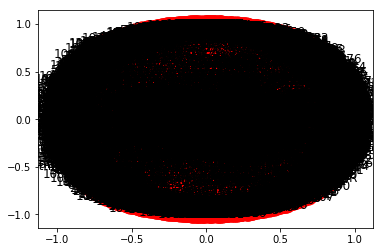

In [10]:
nx.draw_networkx(G, net_pos)

This visualization is a "hairball" and not of any use. 

I am interested in the genes or diseases that impact Amyotrophic lateral sclerosis (ALS), a devastating neurodegenerative disease.

In [19]:
# check if there are nodes corresponding to ALS
G.has_node('AMYOTROPHIC LATERAL SCLEROSIS 1')

True

In [20]:
# list the neighbors of ALS node
list(G.neighbors('AMYOTROPHIC LATERAL SCLEROSIS 1'))

[10736,
 1191,
 120237,
 1270,
 1387,
 1471,
 1509,
 1639,
 170825,
 2251,
 2326,
 2353,
 2554,
 2637,
 2664,
 2670,
 27040,
 283,
 2892,
 3297,
 331,
 340990,
 3718,
 3727,
 3797,
 3949,
 4744,
 5154,
 5179,
 5444,
 5630,
 598,
 6256,
 6404,
 6464,
 6615,
 6647,
 682,
 7074,
 7090,
 7114,
 7124,
 7431,
 7476,
 794,
 834,
 9118,
 924,
 968]

In [21]:
len(list(G.neighbors('AMYOTROPHIC LATERAL SCLEROSIS 1')))

49

In [22]:
# check if there are nodes corresponding to Prostatic Neoplasms
G.has_node('Prostatic Neoplasms')

True

In [23]:
list(G.neighbors('Prostatic Neoplasms'))

[10,
 10013,
 100188789,
 10040,
 1012,
 10158,
 101669767,
 10207,
 10257,
 1026,
 10263,
 1027,
 10333,
 10397,
 10417,
 10439,
 10451,
 10481,
 10499,
 10516,
 10551,
 10587,
 10625,
 10809,
 10857,
 10928,
 10945,
 10948,
 10951,
 10955,
 10961,
 11005,
 11009,
 11176,
 11178,
 11187,
 11200,
 114609,
 116113,
 1191,
 12,
 1200,
 1266,
 1312,
 1316,
 1317,
 1365,
 1366,
 136991,
 1387,
 1410,
 142,
 143686,
 1465,
 1469,
 1474,
 1488,
 1499,
 150084,
 1508,
 1509,
 153090,
 154,
 1543,
 1545,
 1548,
 1557,
 1562,
 1571,
 1576,
 1577,
 1586,
 1588,
 1605,
 1636,
 1647,
 1672,
 1728,
 1775,
 1786,
 1789,
 1902,
 1950,
 1956,
 1958,
 196,
 2012,
 2014,
 2052,
 2064,
 2065,
 2068,
 207,
 2078,
 2099,
 210,
 2100,
 2115,
 2118,
 2146,
 2182,
 2192,
 221895,
 222546,
 2247,
 2255,
 2264,
 2272,
 22853,
 2296,
 23071,
 23197,
 23204,
 23301,
 23382,
 23411,
 2346,
 23476,
 23600,
 23635,
 23671,
 23753,
 246778,
 25792,
 25818,
 2591,
 25932,
 26227,
 26298,
 26499,
 2650,
 2678,
 2690,
 

In [24]:
len(list(G.neighbors('Prostatic Neoplasms')))

485

In [29]:
len(list(G.neighbors('Mammary Neoplasms')))

433

In [35]:
len(list(G.neighbors('IGA Glomerulonephritis')))

450

In [25]:
# check if graph is of bipartite structure
bipartite.is_bipartite(G)

True

The underlying network structure of the disease-gene network is a bipartite graph.

In [26]:
try:
   # Find and print node sets
    left, right = bipartite.sets(G)
    print("Left nodes\n", left)
    print("\nRight nodes\n", right)
except NetworkXError as e:
    # Not an affiliation network
    print(e)

Left nodes
 {'Mouth Neoplasms', 'West Syndrome', 'Chloracne', 'Neoplasms, Experimental', 'Tachycardia, Ventricular', 'Renal Cell Carcinoma', 'Movement Disorders', 'Alopecia', 'Idiopathic generalized epilepsy', 'Cleft Lip', 'Hypercholesterolemia', 'Female infertility', 'Adrenocortical carcinoma', 'Calcinosis', 'Walker-Warburg congenital muscular dystrophy', 'Lung diseases', 'Metabolic Syndrome X', 'Head and Neck Neoplasms', 'Sudden infant death syndrome', 'Multiple Sclerosis', 'Neoplastic Cell Transformation', 'Spontaneous abortion', 'Weight decreased', 'Hepatitis C', 'Berylliosis', 'Fetal Growth Retardation', 'Malaria', 'hearing impairment', 'Adenomatous Polyposis Coli', 'Albuminuria', 'Jeune thoracic dystrophy', 'Hereditary Nonpolyposis Colorectal Cancer', 'Diabetic Cardiomyopathies', 'Mesothelioma', 'Anemia, Sickle Cell', 'Nephrotic Syndrome', 'Stevens-Johnson Syndrome', 'Aortic Valve Insufficiency', 'ovarian neoplasm', 'Pneumonia', 'Dyskeratosis Congenita', 'Schizophrenia, Childhood

NetworkX finds two sets of nodes.

## 3. Microscale Structure Exploration

Numerical measures that characterize the network properties of a node are called centrality measures. Centrality is often introduced as a measure of importance, but there are many ways in which a node can be important. For example, one of the simplest centrality measures is degree centrality. A node's degree centrality is just the number of neighbors it has (in a directed network, there is both in-degree and out-degree)

Betweenness, eigenvector, and closeness centrality all characterize a node by its relation to other nodes in the network.

In [27]:
degree = nx.degree_centrality(G)
sorted(degree.items(), key=lambda x:x[1], reverse=True)[0:10]

[('Prostatic Neoplasms', 0.062083973374295956),
 ('IGA Glomerulonephritis', 0.0576036866359447),
 ('Mammary Neoplasms', 0.05542754736303123),
 ('Obesity', 0.038146441372247826),
 ('Peripheral Neuropathy', 0.03750640040962622),
 ('Stomach Neoplasms', 0.03635432667690732),
 ('Schizophrenia', 0.035842293906810034),
 ('Autistic Disorder', 0.032514080901177675),
 ('Colorectal Neoplasms', 0.029697900665642603),
 ('Liver carcinoma', 0.028417818740399385)]

In [28]:
betweenness = nx.betweenness_centrality(G)
sorted(betweenness.items(), key=lambda x:x[1], reverse=True)[0:10]

[('Prostatic Neoplasms', 0.08448547873501126),
 ('IGA Glomerulonephritis', 0.08252545343054943),
 ('Mammary Neoplasms', 0.07109085758087656),
 ('Obesity', 0.052506459885290034),
 ('Schizophrenia', 0.05011906816152969),
 ('Peripheral Neuropathy', 0.04926193427966431),
 ('Autistic Disorder', 0.04142355523247709),
 ('Stomach Neoplasms', 0.040691910179832064),
 (7124, 0.039549941591934576),
 ('Colorectal Neoplasms', 0.03286026412589331)]

The more well-connected a node, the higher the eigenvector centrality.

In [78]:
# prints top 10 hubs in network
eigenvector = nx.eigenvector_centrality_numpy(G)
sorted(eigenvector.items(), key=lambda x:x[1], reverse=True)[0:10]

[('Mammary Neoplasms', 0.2378688621768061),
 ('Prostatic Neoplasms', 0.23692427382306303),
 ('Stomach Neoplasms', 0.14454573494155873),
 (7124, 0.1358474416470904),
 (6648, 0.1264249480530355),
 ('Lung Neoplasms', 0.12569580953703383),
 ('Liver carcinoma', 0.12470022782269755),
 (5743, 0.1163431398982281),
 (3569, 0.11332690749505271),
 ('Neoplasm Metastasis', 0.11053272263747685)]

A node with high closeness centrality is literally close to other nodes. Nodes with high closeness have, on average, short paths to many other nodes, which can be helpful for

In [43]:
closeness = nx.closeness_centrality(G)
sorted(closeness.items(), key=lambda x:x[1], reverse=True)[0:10]

[(7124, 0.34076335877862596),
 ('Mammary Neoplasms', 0.33944555487963846),
 ('Prostatic Neoplasms', 0.3372183372183372),
 (6648, 0.33613011488318056),
 (3569, 0.33300652201713626),
 ('Stomach Neoplasms', 0.33222760908395),
 ('Peripheral Neuropathy', 0.33157894736842103),
 ('Colorectal Neoplasms', 0.3293145603237501),
 ('IGA Glomerulonephritis', 0.3293145603237501),
 ('Schizophrenia', 0.3287048725069427)]

If an individual's local clustering coefficient is low, it suggests they aren't well-connected. If the coefficient is high, it suggests that an individual's connections are redundant. So, the most central individuals have high absolute numbers of triangles, but midrange local clustering coefficients.

In [44]:
triangles = nx.triangles(G)
sorted(triangles.items(), key=lambda x:x[1], reverse=True)[0:10]

[('Salivary Gland Neoplasms', 0),
 (1462, 0),
 (1612, 0),
 (182, 0),
 (2011, 0),
 (2019, 0),
 (2175, 0),
 (2195, 0),
 (23209, 0),
 (23543, 0)]

In [79]:
clustering = nx.clustering(G)
[(x, clustering[x]) for x in sorted(clustering, key=lambda x:eigenvector[x], reverse=True)[0:10]]

[('Mammary Neoplasms', 0),
 ('Prostatic Neoplasms', 0),
 ('Stomach Neoplasms', 0),
 (7124, 0),
 (6648, 0),
 ('Lung Neoplasms', 0),
 ('Liver carcinoma', 0),
 (5743, 0),
 (3569, 0),
 ('Neoplasm Metastasis', 0)]

I don´t know how to interpret this data if all values are 0.

### Degree distribution 

The subsequent codes were taken from https://www.coursera.org/learn/python-social-network-analysis/home/week/1

In [32]:
def plotDegDistLogLog(G, loglog = True):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    frac = [n/G.number_of_nodes() for n in cnt]
    fig, ax = plt.subplots()
    plt.plot(deg, frac, 'o')
    if loglog:
        ax.set_yscale('log', nonposy='clip')
        ax.set_xscale('log', nonposx='clip')
    plt.ylabel("Fraction of nodes")
    plt.xlabel("Degree")

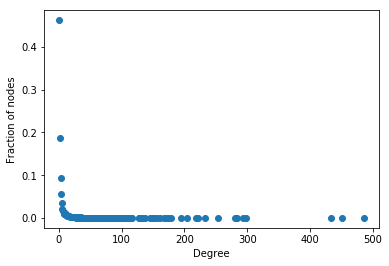

In [33]:
plotDegDistLogLog(G, loglog = False)
plt.savefig('degdist.png')

### PageRank

In [34]:
page_rank = nx.pagerank(G, alpha=0.85)
sorted(page_rank.items(), key=lambda x:x[1], reverse=True)[0:10]

[('IGA Glomerulonephritis', 0.0133446754900095),
 ('Prostatic Neoplasms', 0.010951266568170848),
 ('Mammary Neoplasms', 0.008862372184449322),
 ('Schizophrenia', 0.007443934398555977),
 ('Obesity', 0.00730026330667749),
 ('Peripheral Neuropathy', 0.007220646935901518),
 ('Autistic Disorder', 0.00575435453411143),
 ('Stomach Neoplasms', 0.005633841607714413),
 ('melanoma', 0.00507446473333938),
 ('Colorectal Neoplasms', 0.0049195303907167715)]

## 3. Large Scale Structures

Finding distances and shortest paths.

In [48]:
def path_length_histogram(G, title=None):
    # Find path lengths
    length_source_target = dict(nx.shortest_path_length(G))
    # Convert dict of dicts to flat list
    all_shortest = sum([
        list(length_target.values())
        for length_target
        in length_source_target.values()],
    [])
    # Calculate integer bins
    high = max(all_shortest)
    bins = [-0.5 + i for i in range(high + 2)]
    # Plot histogram
    plt.hist(all_shortest, bins=bins, rwidth=0.8)
    plt.title(title)
    plt.xlabel("Distance")
    plt.ylabel("Count")

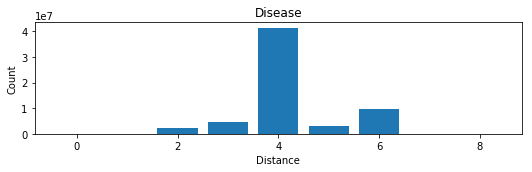

In [49]:
plt.figure(figsize=(7.5, 2.5))
path_length_histogram(G, title="Disease")
plt.tight_layout()

In [50]:
# mean shortest path length
nx.average_shortest_path_length(G)

4.230507611056159

In [51]:
# calculate largest path length i.e. diameter
nx.diameter(G)

8

The simplest measure of large-scale clustering is transitivity: the fraction of possible triangles that are present.

In [52]:
nx.transitivity(G)

0

In [53]:
# or calculate averaged clustering coefficient
nx.average_clustering(G)

0.0

In [54]:
# calculate densitiy, the fraction of possible edges that exist
nx.density(G)

0.000699826178866488

A network is generally considered sparse if the number of edges is close to N (the number of nodes), and dense if the number of edges is close to N2.

How many nodes and edges need to be removed in order to separate the graph?

In [55]:
nx.node_connectivity(G)

1

In [56]:
nx.edge_connectivity(G)

1

In [59]:
def gini(x):
    x = [xi for xi in x]
    n = len(x)
    gini_num = sum([sum([abs(x_i - x_j) for x_j in x]) for x_i in x])
    gini_den = 2.0 * n * sum(x)
    return gini_num / gini_den

In [80]:
gini(nx.eigenvector_centrality_numpy(G).values())

0.6672426076543

## 4. Explore the medium-scale structure of the network

In [37]:
# Find communities using Clauset-Newman-Moore method 
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

In [38]:
# Count the communities
len(communities)

25

In [39]:
communities

[frozenset({2,
            10,
            8202,
            100048912,
            21,
            24,
            25,
            8216,
            57381,
            8233,
            245806,
            50,
            8243,
            51,
            'Adrenocortical carcinoma',
            60,
            'Head and Neck Neoplasms',
            72,
            122953,
            57419,
            729177,
            90,
            92,
            8289,
            114795,
            8312,
            8313,
            8314,
            123,
            125,
            8320,
            131,
            114826,
            8332,
            57492,
            8342,
            'Adenomatous Polyposis Coli',
            8347,
            57509,
            8358,
            57510,
            172,
            'Hereditary Nonpolyposis Colorectal Cancer',
            174,
            'Mesothelioma',
            57522,
            182,
            'ovarian neoplasm',
            20

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(-1.021069586277008,
 1.0751872658729553,
 -1.098389959335327,
 1.0661904573440548)

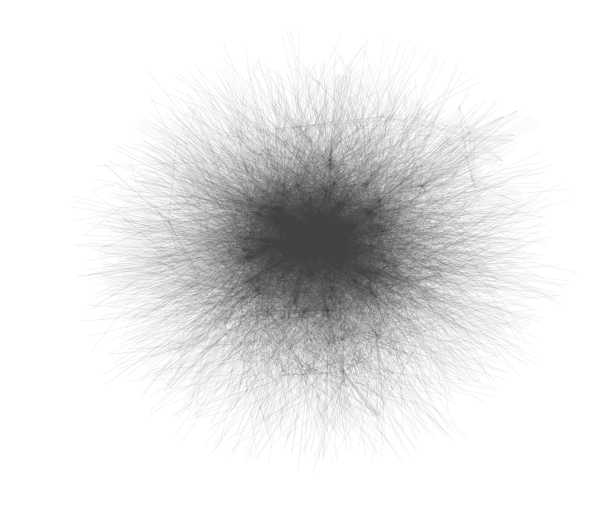

In [40]:
pos = nx.spring_layout(G, k=0.1)
plt.figure(figsize=(10,9))
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edge_color="#333333", alpha=0.05, with_labels=False)
plt.axis('off')

In [46]:
def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

In [47]:
 def set_edge_community(G):
        '''Find internal edges and add their community to their attributes'''
        for v, w, in G.edges:
            if G.nodes[v]['community'] == G.nodes[w]['community']:
                # Internal edge, mark with community
                G.edges[v, w]['community'] = G.nodes[v]['community']
            else:
                # External edge, mark as 0
                G.edges[v, w]['community'] = 0

In [48]:
 def get_color(i, r_off=1, g_off=1, b_off=1):
        '''Assign a color to a vertex.'''
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)            

In [49]:
set_node_community(G, communities)
set_edge_community(G)

In [50]:
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]
internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]

In [51]:
internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

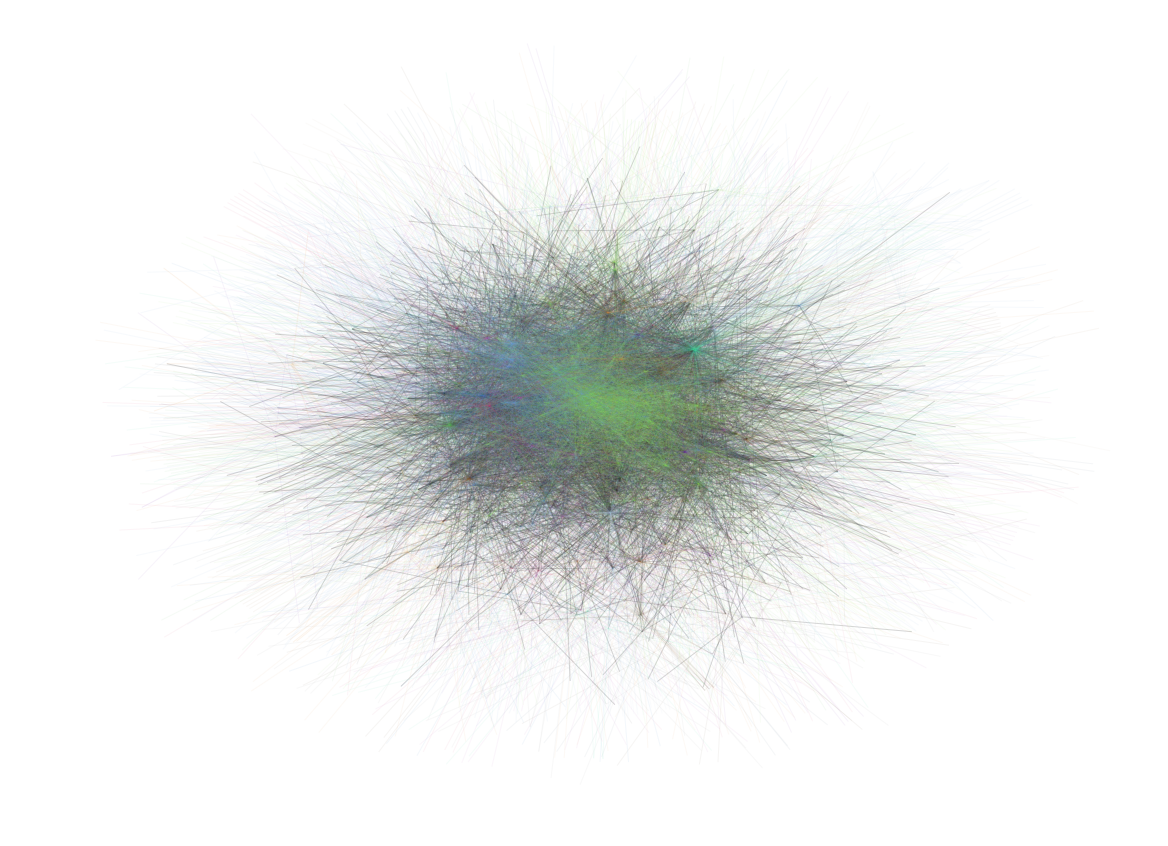

In [53]:
# Draw external edges
plt.figure(figsize=(20,15))
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333",
    alpha=0.2, with_labels=False)
# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=False)
plt.axis('off')
plt.savefig('dg_community.png')

Girvan-Newman method is based on betweenness centrality. Betweenness centralities are first assigned to edges, and then the most central edges are removed until one of the communities is divided into two. This procedure repeats until each node is in its own community. The process can be stopped at any point in order to produce a specific number of communities, or a quality measure such as modularity can be used to estimate a good stopping point.

In [55]:
result = nxcom.girvan_newman(G)
communities_gn = next(result)

In [56]:
len(communities_gn)

2

In [57]:
communities_gn

({102465537,
  2,
  9,
  10,
  12,
  16,
  18,
  19,
  21,
  22,
  23,
  24,
  25,
  26,
  28,
  29,
  31,
  32,
  34,
  36,
  37,
  38,
  40,
  'Alopecia',
  41,
  43,
  163882,
  47,
  48,
  50,
  51,
  54,
  55,
  58,
  59,
  60,
  'Head and Neck Neoplasms',
  70,
  71,
  72,
  81,
  88,
  90,
  91,
  92,
  95,
  98,
  100,
  101,
  102,
  104,
  131177,
  105,
  107,
  108,
  109,
  111,
  113,
  114,
  115,
  116,
  117,
  118,
  120,
  123,
  125,
  126,
  127,
  131,
  132,
  133,
  134,
  135,
  196743,
  140,
  142,
  143,
  147,
  148,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  161,
  163,
  166,
  172,
  173,
  174,
  176,
  177,
  178,
  181,
  182,
  183,
  185,
  186,
  191,
  196,
  197,
  'ovarian neoplasm',
  199,
  203,
  204,
  205,
  207,
  208,
  210,
  212,
  213,
  214,
  216,
  217,
  219,
  220,
  225,
  226,
  229,
  231,
  238,
  239,
  240,
  241,
  245,
  246,
  249,
  251,
  'Diaphragmatic Hernia',
  259,
  266,
  267,
  268,
 

Finding Cliques

In [93]:
# find cliques in network i.e. groups of nodes that are all connected to each other
cliques = list(nx.find_cliques(G))
cliques

[[102465537, 'Diffuse Large B-Cell Lymphoma'],
 [102465537, 'Dermatitis, Atopic'],
 [2, 'Colonic Neoplasms'],
 [2, 'Liver carcinoma'],
 [2, 'Nephrotic Syndrome'],
 [2, 'Acute kidney injury'],
 [2, 'Lung Neoplasms'],
 [2, 'Lung diseases'],
 [2, "Alzheimer's Disease"],
 [2, 'Hepatolenticular Degeneration'],
 [81928, 'Colorectal Cancer'],
 [81930, 'IGA Glomerulonephritis'],
 ['Mucocutaneous Lymph Node Syndrome', 640],
 ['Mucocutaneous Lymph Node Syndrome', 79682],
 ['Mucocutaneous Lymph Node Syndrome', 2212],
 ['Mucocutaneous Lymph Node Syndrome', 3781],
 ['Mucocutaneous Lymph Node Syndrome', 101927078],
 ['Mucocutaneous Lymph Node Syndrome', 254827],
 ['Mucocutaneous Lymph Node Syndrome', 100529262],
 ['Mucocutaneous Lymph Node Syndrome', 80271],
 ['Mucocutaneous Lymph Node Syndrome', 958],
 ['Mucocutaneous Lymph Node Syndrome', 90390],
 ['Mucocutaneous Lymph Node Syndrome', 79934],
 ['Mucocutaneous Lymph Node Syndrome', 253017],
 ['Mucocutaneous Lymph Node Syndrome', 8190],
 [16, 'Charc

In [94]:
# find maximal clique, the largest clique and the densest area of the network
# Find max clique
max_clique = max(cliques, key=len)
max_clique

[102465537, 'Diffuse Large B-Cell Lymphoma']

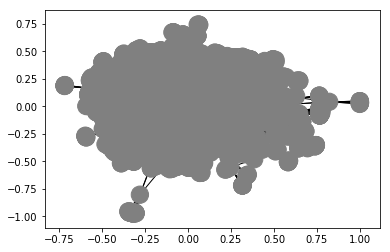

In [97]:
# Visualize maximum/maximal? clique
node_color = [(0.5, 0.5, 0.5) for v in G.nodes()]
for i, v in enumerate(G.nodes()):
    if v in max_clique:
        node_color[i] = (0.5, 0.5, 0.9)
nx.draw_networkx(G, node_color=node_color, with_labels=False)

Use k-cores to find dense network regions

In [68]:
# Find k-cores
G_core_30 = nx.k_core(G, 30)
G_core_60 = nx.k_core(G, 60)

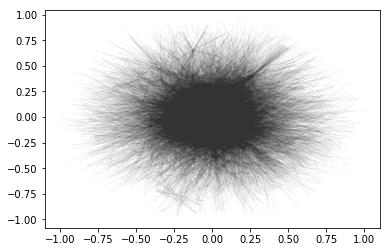

In [69]:
# Visualize network and k-cores
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edge_color="#333333", alpha=0.05, with_labels=False)
nx.draw_networkx(
    G_core_30, pos=pos, node_size=0,
    edge_color="#7F7FEF", alpha=0.05, with_labels=False)
nx.draw_networkx(
    G_core_60, pos=pos, node_size=0,
    edge_color="#AFAF33", alpha=0.05, with_labels=False)

In [76]:
nx.write_gexf(G, "disease_gene_network.gexf")

## Visualizing the network 

In [161]:
# See what layouts are available in networkX
[x for x in nx.__dir__() if x.endswith('_layout')]

['bipartite_layout',
 'circular_layout',
 'kamada_kawai_layout',
 'random_layout',
 'rescale_layout',
 'shell_layout',
 'spring_layout',
 'spectral_layout',
 'fruchterman_reingold_layout']

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


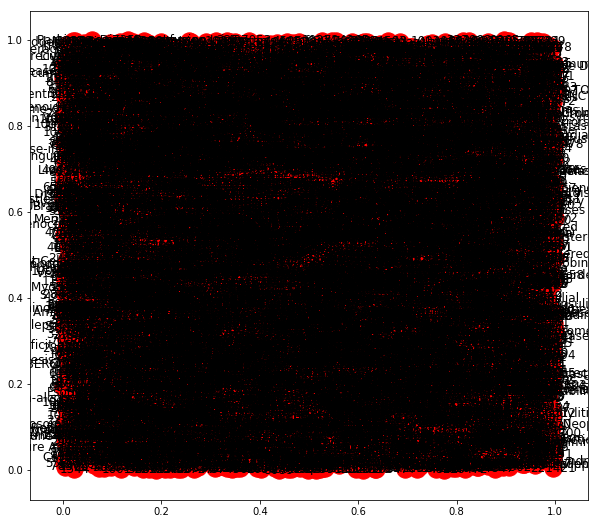

In [162]:
# Draw the graph using the random layout
plt.figure(figsize=(10,9))
pos = nx.random_layout(G)
nx.draw_networkx(G, pos)

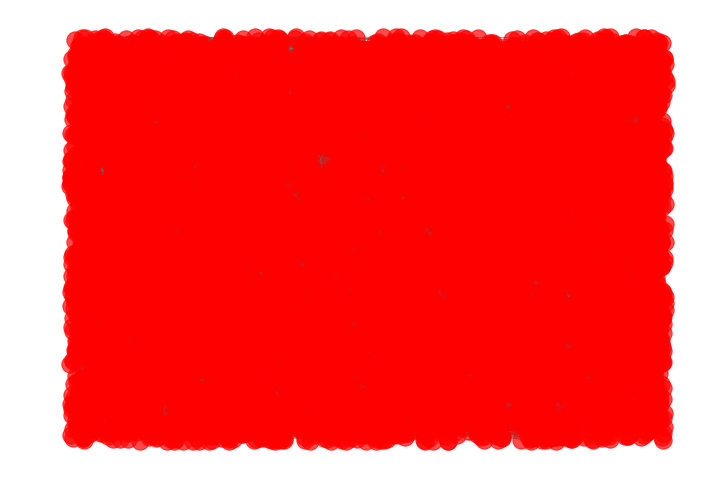

In [163]:
# Draw the graph adding alpha, removing labels, and softening edge color
plt.figure(figsize=(10,7))

nx.draw_networkx(G, pos, alpha=0.7, with_labels=False, edge_color='.4')

plt.axis('off')
plt.tight_layout();